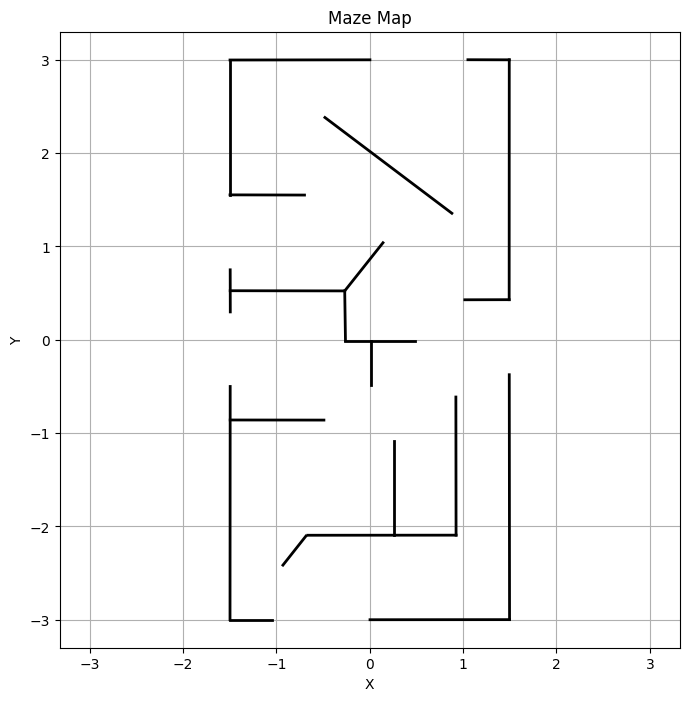

In [2]:
import yaml
import matplotlib.pyplot as plt

def load_maze_config(yaml_file):
    with open(yaml_file, "r") as f:
        config = yaml.safe_load(f)
    return config["maze"]["walls"]

def plot_maze(walls):
    plt.figure(figsize=(8, 8))
    for wall in walls:
        start = wall["start"]
        end = wall["end"]
        # Plot the wall as a black line
        plt.plot([start[0], end[0]], [start[1], end[1]], "k-", linewidth=2)
    plt.xlabel("X")
    plt.ylabel("Y")
    plt.title("Maze Map")
    plt.axis("equal")
    plt.grid(True)
    plt.show()

if __name__ == "__main__":
    # Path to your YAML config file
    yaml_file = "/home/federico/isaaclab/IsaacLab/source/isaaclab_tasks/isaaclab_tasks/direct/jetbot/maze_confi.yaml"  
    walls = load_maze_config(yaml_file)
    plot_maze(walls)

In [60]:
import math
import os
import yaml
import matplotlib.pyplot as plt
import numpy as np

class Maze:
    def __init__(self, cfg_path="/home/federico/isaaclab/IsaacLab/source/isaaclab_tasks/isaaclab_tasks/direct/jetbot/maze_cfg.yaml"):
        self.walls = []
        self.config_path = cfg_path

        with open(self.config_path, "r") as f:
            maze_config = yaml.safe_load(f)
        self.walls = maze_config["maze"]["walls"]

    def spawn_maze(self, width=0.5, height=0.5, walls=None):
        if walls is None:
            walls = self.walls

        self.width = width
        self.height = height

        self.walls_start = [wall["start"] for wall in walls]
        self.walls_end = [wall["end"] for wall in walls]

    def plot_maze(self, robot_positions=None):
        """
        Plot the maze in 2D using matplotlib and plot robot positions.
        robot_positions: List of robot positions to plot (e.g., [(x1, y1), (x2, y2), ...])
        """
        # Plot walls as thick lines
        for wall in self.walls:
            start = np.array(wall["start"])
            end = np.array(wall["end"])
            plt.plot([start[0], end[0]], [start[1], end[1]], color='black', linewidth=1)  # Multiply by 10 to make it thicker

        # Plot robots
        if robot_positions is not None:
            robot_positions = np.array(robot_positions)
            plt.scatter(robot_positions[:, 0], robot_positions[:, 1], color='red', s=50, label='Robots')

        # Set labels and show plot
        plt.xlabel('X position')
        plt.ylabel('Y position')
        plt.title('Maze with Robot Positions')
        plt.legend()
        plt.grid(True)
        plt.axis('equal')
        plt.show()

    def distance_from_line(self, point, start, end):
        """
        Compute perpendicular distance from point to the line defined by start and end.
        """
        p = np.array(point)
        s = np.array(start)
        e = np.array(end)

        if np.allclose(s, e):
            return np.linalg.norm(p - s)
        return np.abs(np.cross(e-s, s-p)) / np.linalg.norm(e-s)

    def check_collision(self, pos):
        """
        Compute the distances from each robot (given by their positions pos)
        to each wall defined by its start and end points.
        """
        walls_start = np.array(self.walls_start)  # shape: [num_walls, 2]
        walls_end = np.array(self.walls_end)      # shape: [num_walls, 2]
        
        # Compute wall direction vectors and their squared lengths
        wall_dirs = walls_end - walls_start            # shape: [num_walls, 2]
        norm_wall_dirs_sq = (wall_dirs ** 2).sum(axis=1)  # shape: [num_walls]
        norm_wall_dirs_sq = np.where(norm_wall_dirs_sq == 0, 1e-6, norm_wall_dirs_sq)  # Avoid division by zero
        
        # Reshape norm_wall_dirs_sq to make it broadcastable with the dot product
        norm_wall_dirs_sq = norm_wall_dirs_sq[None, :]  # shape: [1, num_walls]
        
        # Compute vector from wall start to each robot position
        pos_exp = np.array(pos)[:, None, :]              # shape: [num_robots, 1, 2]
        walls_start_exp = walls_start[None, :, :]        # shape: [1, num_walls, 2]
        wall_dirs_exp = wall_dirs[None, :, :]            # shape: [1, num_walls, 2]
        walls_end_exp = walls_end[None, :, :]            # shape: [1, num_walls, 2]

        # Compute the projection parameter t for each robot-wall pair:
        vec = pos_exp - walls_start_exp          # shape: [num_robots, num_walls, 2]
        dot = np.sum(vec * wall_dirs_exp, axis=2)  # shape: [num_robots, num_walls]
        t = dot / norm_wall_dirs_sq              # shape: [num_robots, num_walls]
        
        # Compute the projection point on the infinite line: P_proj = A + t*(B-A)
        p_proj = walls_start_exp + t[..., None] * wall_dirs_exp  # shape: [num_robots, num_walls, 2]

        # Compute perpendicular distance (d_perp) to the infinite line
        d_perp = np.linalg.norm(pos_exp - p_proj, axis=2)           # shape: [num_robots, num_walls]

        # --- Case 1: When projection falls on the segment (0 <= t <= 1) ---
        mask_inside = (t >= 0.0) & (t <= 1.0)  # shape: [num_robots, num_walls]
        d_on_segment = np.maximum(d_perp - self.width / 2.0, 0.0)  # adjusted distance when on segment

        # --- Case 2: When projection falls outside the segment (t < 0 or t > 1) ---
        mask_outside = ~mask_inside

        # For outside cases, determine the closest endpoint.
        d_ep_A = np.linalg.norm(p_proj - walls_start_exp, axis=2)  # distance from projection to start, shape: [num_robots, num_walls]
        d_ep_B = np.linalg.norm(p_proj - walls_end_exp, axis=2)    # distance from projection to end, shape: [num_robots, num_walls]
        
        # Ensure correct shapes for broadcasting:
        d_ep_A = np.expand_dims(d_ep_A, axis=0)  # shape: [1, num_robots, num_walls]
        d_ep_B = np.expand_dims(d_ep_B, axis=0)  # shape: [1, num_robots, num_walls]
        
        d_ep = np.where(t < 0, d_ep_A, d_ep_B)  # shape: [num_robots, num_walls]

        # Now, for outside cases, further decide:
        corner_distance = np.sqrt(d_ep**2 + (d_perp - self.width / 2.0)**2)
        d_outside = np.where(d_perp < self.width / 2.0, d_ep, corner_distance)

        # For outside, use d_outside; for inside, use d_on_segment.
        final_dists = np.where(mask_inside, d_on_segment, d_outside)  # shape: [num_robots, num_walls]

        # Remove the extra dimension at index 0 (if it exists)
        final_dists = np.squeeze(final_dists, axis=0)  # shape: [num_robots, num_walls]

        # Sort the distances along axis 1 (for each robot)
        sorted_dists = np.sort(final_dists, axis=1)  # shape: [num_robots, num_walls]

        # Select the smallest 3 distances for each robot
        smallest3 = sorted_dists[:, :3]  # shape: [num_robots, 3]

        return smallest3



    def move_walls(self, percent):
        new_walls = []
        for wall in self.walls:
            start = np.array(wall["start"])
            end = np.array(wall["end"])
            dx = end[0] - start[0]
            dy = end[1] - start[1]
            new_start = [start[0] + dx * percent, start[1] + dy * percent]
            new_end = [end[0] + dx * percent, end[1] + dy * percent]
            new_walls.append({"start": new_start, "end": new_end})
        self.walls = new_walls  # Update the maze with the moved walls


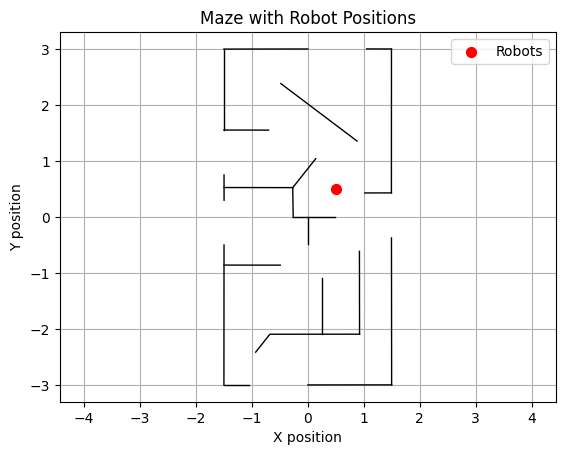

Distances:  [[0.25877403 0.36700894 0.51784938]]


In [68]:
maze = Maze("/home/federico/isaaclab/IsaacLab/source/isaaclab_tasks/isaaclab_tasks/direct/jetbot/maze_cfg.yaml")

# Define some robot positions
robot_positions = [(0.5, 0.5)]

maze.spawn_maze()

# Plot the maze with robots
maze.plot_maze(robot_positions)

# Compute distances from the robots to walls
distances = maze.check_collision(robot_positions)

print("Distances: ", distances)